# The False Mirror, 1928 by Rene Magritte

![The false mirror](https://raw.githubusercontent.com/asyaf/magritte/master/images/false_mirror.jpg)

# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 

In [30]:
!wget https://raw.githubusercontent.com/asyaf/magritte/master/code/utils.py

from utils import load_image, resize_image, display_image, \
                  display_images, alpha_blend, mask_to_gray

--2020-01-09 16:10:34--  https://raw.githubusercontent.com/asyaf/magritte/master/code/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2831 (2.8K) [text/plain]
Saving to: ‘utils.py.2’

utils.py.2          100%[===================>]   2.76K  --.-KB/s    in 0s      

2020-01-09 16:10:34 (51.4 MB/s) - ‘utils.py.2’ saved [2831/2831]



In [0]:
IMG_PATH = "drive/My Drive/Data/magritte data"
EYE_IMG = "eye.jpg"
EYE_IMG_PATH = os.path.join(IMG_PATH, EYE_IMG)
SKY_IMG = "sky.jpg"
SKY_IMG_PATH = os.path.join(IMG_PATH, SKY_IMG)

# Check image and channels

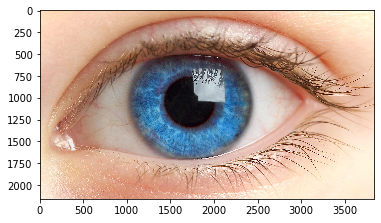

In [5]:
eye_img = load_image(EYE_IMG_PATH)
display_image(eye_img)

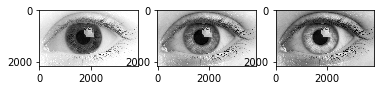

In [6]:
red, green, blue = cv2.split(eye_img)
display_images([red, green, blue])

# Visualize problems with HSV colorspace

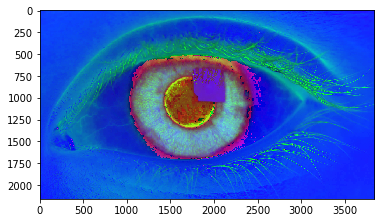

In [7]:
hsv_eye_img = cv2.cvtColor(eye_img, cv2.COLOR_RGB2HSV)
display_image(hsv_eye_img)

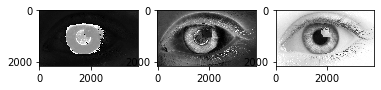

In [8]:
hue, saturation, value = cv2.split(hsv_eye_img)
img_list = [hue, saturation, value]
display_images(img_list)

# Find iris

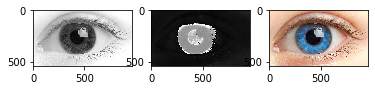

In [9]:
new_h, new_w, _ = (np.array(eye_img.shape) / 4).astype(np.uint32) 
resized_red = resize_image(red, new_w, new_h)
resized_hue = resize_image(hue, new_w, new_h)
resized_eye_img = resize_image(eye_img, new_w, new_h)
img_list = [resized_red, resized_hue, resized_eye_img]
display_images(img_list)

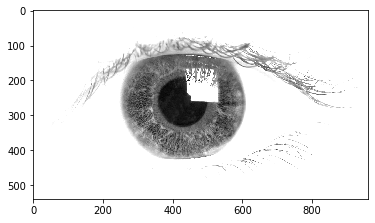

In [10]:
alpha = 1.5 # Contrast control (1.0-3.0)
beta = 30 # Brightness control (0-100)
adjusted_red = cv2.convertScaleAbs(resized_red, alpha=alpha, beta=beta)
display_image(adjusted_red)

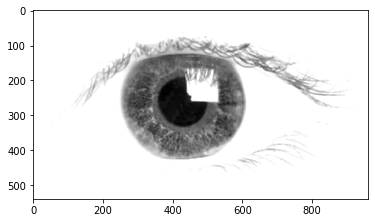

In [11]:
blurred_red_img = cv2.blur(adjusted_red, (5,5))
display_image(blurred_red_img)

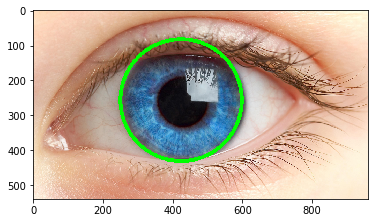

In [12]:
circles = cv2.HoughCircles(blurred_red_img,cv2.HOUGH_GRADIENT,1.5,20, \
                           param1=100, param2=70, 
                           minRadius=150, maxRadius=200)

res_img = resized_eye_img.copy()
mask = np.zeros(())
if circles is not None:
  circles = np.around(circles)
  for i in circles[0,:]:
    # draw the outer circle
    x, y, r = i
    cv2.circle(res_img,(x, y), r,(0,255,0),10)
  display_image(res_img)
else:
  print("No circles found")

In [13]:
iris = circles[0][0]
print(iris)

[424. 257. 174.]


# Create iris mask

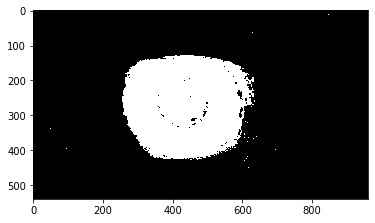

In [14]:
ret, thresh = cv2.threshold(resized_hue,80,255,cv2.THRESH_BINARY)
display_image(thresh)

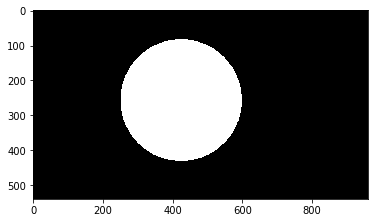

In [38]:
black_img = np.zeros(resized_hue.shape, dtype=np.uint8)
cv2.circle(black_img, (iris[0], iris[1]), iris[2], (255,255,255), -1)
display_image(black_img)

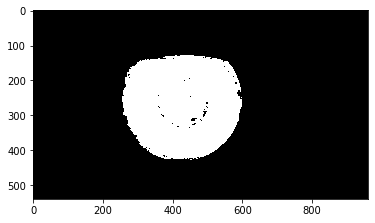

In [40]:
corrected_mask = cv2.bitwise_and(thresh, black_img)
display_image(corrected_mask)

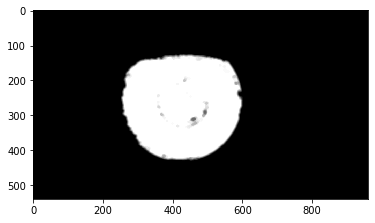

In [41]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
iris_mask = cv2.blur(corrected_mask, (7,7))
for i in range(3):
  iris_mask = cv2.morphologyEx(iris_mask,cv2.MORPH_OPEN,kernel)
  iris_mask = cv2.morphologyEx(iris_mask,cv2.MORPH_CLOSE,kernel)
display_image(iris_mask)

# Handle sky

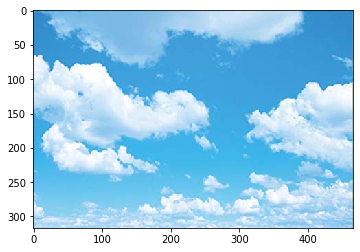

In [16]:
sky_img = load_image(SKY_IMG_PATH)
display_image(sky_img)

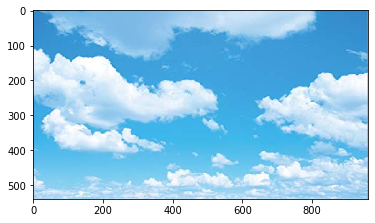

In [17]:
resized_sky_img = resize_image(sky_img, new_w, new_h)
display_image(resized_sky_img)

# Combine and draw pupil

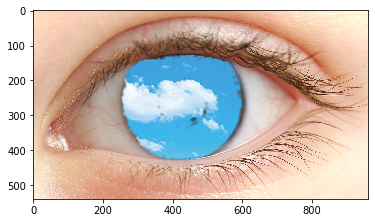

In [42]:
iris_mask_img = cv2.merge([iris_mask] * 3)
eye_sky_img = alpha_blend(resized_sky_img, resized_eye_img, iris_mask_img)
eye_sky_img = eye_sky_img.astype(np.uint8)
display_image(eye_sky_img)

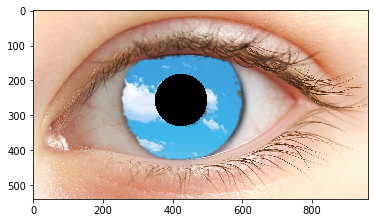

In [45]:
eye_sky_pupil_img = eye_sky_img.copy()
cv2.circle(eye_sky_pupil_img, (iris[0], iris[1]), 75, (0, 0, 0), -1)
display_image(eye_sky_pupil_img)